# Parsing 1000Z Rigol Waveforms

**Scott Prahl**

**Feb 2020**

## Introduction

The goal of this notebook is to explain the origins of the raw data to voltage conversion on the Rigol 1000Z oscilloscope `.wfm` files.

- MSO1054Z and DS1054Z 
- MSO1074Z and DS1074Z
- MSO1104Z and DS1104Z 

The file format extracts the `volts_per_division` and `volts_offset` values, but using these with raw data required reading the [Rigol Programming Guide](https://www.batronix.com/pdf/Rigol/ProgrammingGuide/MSO1000Z_DS1000Z_ProgrammingGuide_EN.pdf) for the DS1000Z.

Two different `.wfm` files are examined, one for the [MSO1104Z](https://github.com/michal-szkutnik/pyRigolWfm1000Z/issues/1#issuecomment-212646090), one each for the [DS1074Z and DS1074Z Plus](https://github.com/michal-szkutnik/pyRigolWfm1000Z/issues/4#issue-361649641).

**There is still something screwy about the conversion of raw bytes to volts.**

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

try:
    import RigolWFM.wfme as wfme

except:
    print("***** You need to install the module to read Rigol files first *****")
    print("***** Execute the following line in a new cell, then retry     *****")
    print()
    print("!{sys.executable} -m pip install RigolWFM")
    
def downsample(y, new_length):
    """Create new array with specifed length by averaging points."""
    ynew = np.empty(new_length)
    stride = len(y)/new_length
    for i in range(new_length):
        start = int(i*stride)
        end = int(i*stride+stride)
        ynew[i] = np.mean(y[start:end])
        
    return ynew

## Background on the voltage and time conversions.

It is bit confusing because the `.wfm` files and the `.csv` files can differ.  I think that the `.wfm` files always correspond to the scope's `RAW` mode and the `.csv` files can be limited to just the display or `NORMAL` mode.

### Voltage conversion

From the [Rigol Programming Guide](https://www.batronix.com/pdf/Rigol/ProgrammingGuide/MSO1000Z_DS1000Z_ProgrammingGuide_EN.pdf)
    
page 2-221::
>    volts = (raw_byte - YORigin - YREFerence) * YINCrement

page 2-223, assuming `RAW` mode::
>    YINCrement = VerticalScale/25

>    YORigin = VerticalOffset/YINCrement

>    YREFerence is always 127
    
So this becomes::
>    volts = (raw_byte - VerticalOffset/YINCrement - 127) * YINCrement

>    volts = (raw_byte - 127) * YINCrement - VerticalOffset

>    volts = (raw_byte - 127.0) * VerticalScale/25.0 - VerticalOffset

Where the decimal points are needed to force python to do all math with floats.

### Time Conversions

On page 2-222 we find that

`XINCrement` the time difference between two neighboring points of the specified channel source in the X direction and

> XINCrement = 1/SampleRate

on the other hand, when the scope is in `NORMAL` mode or display mode, then

> XINCrement = TimeScale/100

`XORigin` is the start time of the waveform data of the channel source currently selected in the X direction.

Both should be in seconds.

## Start with waveform with a single trace

Start with a `.wfm` file from a Rigol MSO1104 scope.

First let's look at the description of the internal file structure. We see that only channel 1 has been enabled.  Unfortunately, there is not an accompanying `.csv` file.

In [2]:
# raw=true is needed because this is a binary file
wfm_filename = "https://github.com/scottprahl/RigolWFM/raw/master/wfm/MSO1104.wfm" + "?raw=true"  

channels = wfme.read_and_parse_file(wfm_filename, kind='1000Z')

for ch in channels:
    print(ch)

working on https://github.com/scottprahl/RigolWFM/raw/master/wfm/MSO1104.wfm?raw=true
downloading file
Channel 1
    General:
         Scope = MSO1104Z
      Firmware = 00.04.03.SP2
       Enabled = True
    Voltage:
        Scale  = 50 V/div
        Offset = 800 mV
      Coupling = AC
    Time:
        Scale  = 1 ms/div
        Delay  = -200 ps
        Delta  = 1000 ns/point
    Data:
        Points = 1200512
        Raw    = [      174,      175,      176  ...        70,       70]
        Volts  = [   94.8 V,   96.8 V,   98.8 V  ...  -113.2 V, -113.2 V]
        Times  = [-600.256 ms,-600.255 ms,-600.254 ms  ... 600.255 ms,600.256 ms]



There are a lot of points, so just look the first and last 500 bytes in the `.wfm` file. Close-up the signal is a sinusoid.  A quick plot of the beginning and end of the data is shown below.

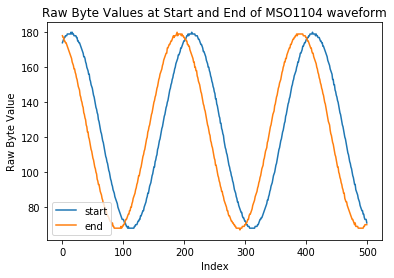

In [3]:
ch = channels[0]
plt.plot(ch.raw[:500], label="start")
plt.plot(ch.raw[-500:], label="end")

plt.xlabel("Index")
plt.ylabel("Raw Byte Value")

plt.title("Raw Byte Values at Start and End of MSO1104 waveform")
plt.legend()
plt.show()

Trying to create a function to convert to volts.  This one is at least plausible.

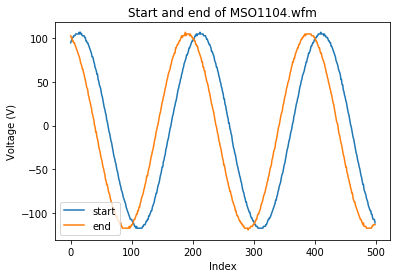

In [4]:
plt.plot(ch.volts[:500], label="start")
plt.plot(ch.volts[-500:], label="end")

plt.xlabel("Index")
plt.ylabel("Voltage (V)")
plt.title("Start and end of MSO1104.wfm")
plt.legend()
plt.show()

And finally, a graph with the real time units.

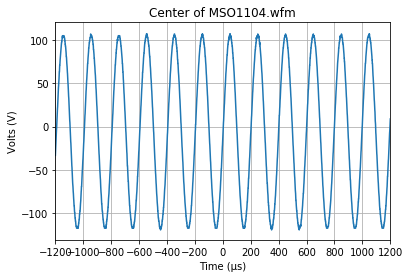

In [5]:
plt.plot(ch.times*1e6, ch.volts)
plt.xlabel("Time (µs)")
plt.ylabel("Volts (V)")
plt.xlim(-1200,1200)
plt.title("Center of MSO1104.wfm")
plt.xticks(np.linspace(-1200,1200,13))
plt.grid(True)
plt.show()

## DS1074Z Scope file

This `.wfm` file has an accompanying `.csv` file.  The difference between these two files is that the `.csv` file has been downsampled to 1200 points.  The `.wfm` has 3000128 bytes.

<img src="https://user-images.githubusercontent.com/43404500/45744052-0b897080-bbed-11e8-8d96-d46fd7e4c9c7.png" width="170%">

Here we just validate that the `.csv` file has the same values

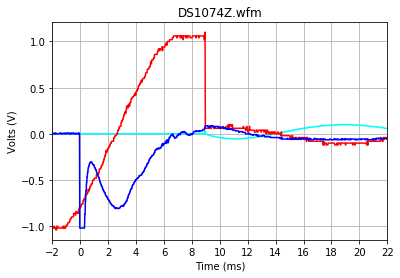

In [6]:
csv_filename = "https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1074Z-A.csv"
csv_data = np.genfromtxt(csv_filename, delimiter=',', skip_header=2).T

# construct times for each point using values from the second line of the .csv file
t_start = -2.000000e-03  # seconds
t_incr = 2.000000e-05    # seconds/point

csv_times = csv_data[0] * t_incr + t_start   # seconds

plt.plot(csv_times*1000, csv_data[1],color='cyan')
plt.plot(csv_times*1000, csv_data[2],color='red')
plt.plot(csv_times*1000, csv_data[3],color='blue')

plt.xlabel("Time (ms)")
plt.ylabel("Volts (V)")
plt.grid(True)
plt.xlim(-2,22)
plt.title("DS1074Z.wfm")
plt.xticks(np.linspace(-2,22,13))

plt.show()

In [7]:
wfm_filename = "https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1074Z-A.wfm" + "?raw=true"  

channels = wfme.read_and_parse_file(wfm_filename, kind='1000Z')

for ch in channels:
    print(ch)

working on https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1074Z-A.wfm?raw=true
downloading file
Channel 1
    General:
         Scope = DS1074Z
      Firmware = 00.04.04.SP3
       Enabled = True
    Voltage:
        Scale  = 50 mV/div
        Offset = 0 V
      Coupling = AC
    Time:
        Scale  = 2 ms/div
        Delay  = 10 ms
        Delta  = 8 ns/point
    Data:
        Points = 3000128
        Raw    = [      115,      115,      115  ...       140,      140]
        Volts  = [   -24 mV,   -24 mV,   -24 mV  ...     26 mV,    26 mV]
        Times  = [-2.00051 ms,-2.0005 ms,-2.0005 ms  ... 22.0005 ms,22.0005 ms]

Channel 2
    General:
         Scope = DS1074Z
      Firmware = 00.04.04.SP3
       Enabled = True
    Voltage:
        Scale  = 500 mV/div
        Offset = 0 V
      Coupling = AC
    Time:
        Scale  = 2 ms/div
        Delay  = 10 ms
        Delta  = 8 ns/point
    Data:
        Points = 3000128
        Raw    = [       54,       53,       54  ...       

Let's examine the second waveform in detail.  The Rigol screenshot shows that it goes from -1V to about 1.1V.  We will use the downsample function defined above to reduce the waveform signal to same number of datapoints as the `.csv` file has.

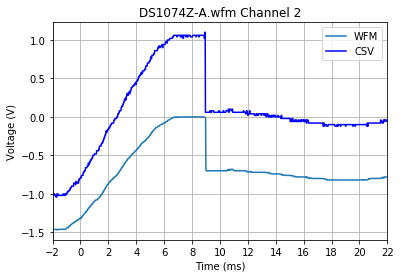

In [8]:
ch = channels[1]
tt = downsample(ch.times, len(csv_data[2]))
vv = downsample(ch.volts, len(csv_data[2]))

plt.plot(tt*1000, vv, label="WFM")
plt.plot(csv_times*1000, csv_data[2],color='blue', label="CSV")

plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")
plt.grid(True)
plt.title("DS1074Z-A.wfm Channel 2")
plt.legend()
plt.xlim(-2,22)
plt.xticks(np.linspace(-2,22,13))

plt.show()

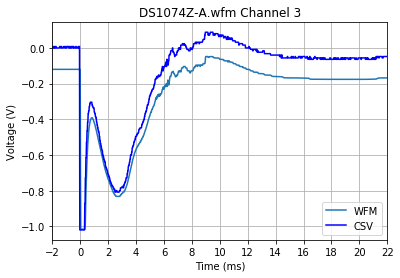

In [9]:
ch = channels[2]
tt = downsample(ch.times, len(csv_data[2]))
vv = downsample(ch.volts, len(csv_data[2]))

plt.plot(tt*1000, vv, label="WFM")
plt.plot(csv_times*1000, csv_data[3],color='blue', label="CSV")

plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")
plt.grid(True)
plt.title("DS1074Z-A.wfm Channel 3")
plt.legend()
plt.xlim(-2,22)
plt.xticks(np.linspace(-2,22,13))

plt.show()

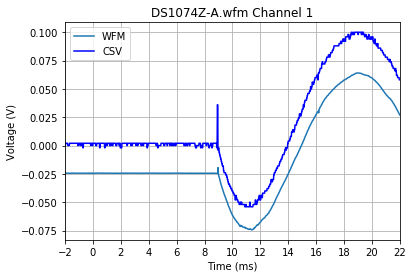

In [10]:
ch = channels[0]
tt = downsample(ch.times, len(csv_data[1]))
vv = downsample(ch.volts, len(csv_data[1]))

plt.plot(tt*1000, vv, label="WFM")
plt.plot(csv_times*1000, csv_data[1],color='blue', label="CSV")

plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")
plt.grid(True)
plt.title("DS1074Z-A.wfm Channel 1")
plt.legend()
plt.xlim(-2,22)
plt.xticks(np.linspace(-2,22,13))

plt.show()

## DS1074Z Plus file

This `.wfm` file has an accompanying `.csv` file.  The difference between these two files is that the `.csv` file has been downsampled to 1200 points.  The `.wfm` has 3000128 bytes.

<img src="https://user-images.githubusercontent.com/43404500/45744062-104e2480-bbed-11e8-936d-b009f3886bb6.png" width="100%">

Here we just validate that the `.csv` file has the same values

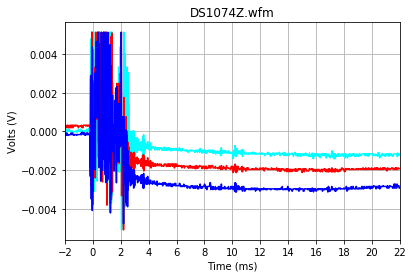

In [11]:
csv_filename = "https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1074Z-B.csv"
csv_data = np.genfromtxt(csv_filename, delimiter=',', skip_header=2).T

# construct times for each point using values from the second line of the .csv file
t_start = -2.000000e-03  # seconds
t_incr = 2.000000e-05    # seconds/point

csv_times = csv_data[0] * t_incr + t_start   # seconds

plt.plot(csv_times*1000, csv_data[1],color='cyan')
plt.plot(csv_times*1000, csv_data[2],color='red')
plt.plot(csv_times*1000, csv_data[3],color='blue')

plt.xlabel("Time (ms)")
plt.ylabel("Volts (V)")
plt.grid(True)
plt.xlim(-2,22)
plt.title("DS1074Z.wfm")
plt.xticks(np.linspace(-2,22,13))

plt.show()

In [12]:
wfm_filename = "https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1074Z-B.wfm" + "?raw=true"  

wfm_filename = "/Users/prahl/Documents/Code/git/RigolWFM/wfm/004y.wfm"

channels = wfme.read_and_parse_file(wfm_filename, kind='1000Z')

for ch in channels:
    print(ch)

working on /Users/prahl/Documents/Code/git/RigolWFM/wfm/004y.wfm
Channel 1
    General:
         Scope = DS1074Z Plus
      Firmware = 00.04.04.SP3
       Enabled = True
    Voltage:
        Scale  = 1 mV/div
        Offset = 0 V
      Coupling = AC
    Time:
        Scale  = 5 µs/div
        Delay  = 9 ms
        Delta  = 8 ns/point
    Data:
        Points = 3000128
        Raw    = [       93,       93,       93  ...        90,       90]
        Volts  = [ -1.36 mV, -1.36 mV, -1.36 mV  ...  -1.48 mV, -1.48 mV]
        Times  = [-3.00051 ms,-3.0005 ms,-3.0005 ms  ... 21.0005 ms,21.0005 ms]

Channel 2
    General:
         Scope = DS1074Z Plus
      Firmware = 00.04.04.SP3
       Enabled = True
    Voltage:
        Scale  = 1 mV/div
        Offset = 0 V
      Coupling = AC
    Time:
        Scale  = 5 µs/div
        Delay  = 9 ms
        Delta  = 8 ns/point
    Data:
        Points = 3000128
        Raw    = [       95,       98,       98  ...       101,      101]
        Volts  = [ -

Unfortunately, the accompanying `.wfm` file does not seem to be same signal as the other two!  See https://github.com/michal-szkutnik/pyRigolWfm1000Z/issues/4#issue-361649641 and specifically the files for the DS1074Z Plus scope.

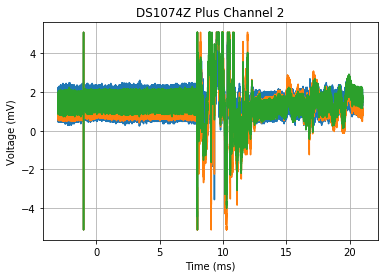

In [13]:
for ch in channels:
    tt = ch.times * 1000
    vv = ch.volts * 1000
    plt.plot(tt,-vv)

plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.grid(True)
plt.title("DS1074Z Plus Channel 2")

plt.show()